In [11]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.utils import Sequence
import cv2
import matplotlib.pyplot as plt

img_size = 224

def load_data(IMAGES_PATH, annotations):
    images = []
    bboxes = []
    
    for index, row in annotations.iterrows():
        
            img_path = os.path.join(IMAGES_PATH, row[0])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image_resized = cv2.resize(image, (img_size, img_size))

            image_resized = image_resized / 255.0
            images.append(image_resized)

            x1, y1, x2, y2 = row[2], row[3], row[4], row[5]
            orig_h = image.shape[0]
            orig_w = image.shape[1]

            x1_scaled = (x1 / orig_w) * img_size
            y1_scaled = (y1 / orig_h) * img_size
            x2_scaled = (x2 / orig_w) * img_size
            y2_scaled = (y2 / orig_h) * img_size

            x1, y1, x2, y2 = row[6], row[7], row[8], row[9]

            xx1_scaled = (x1 / orig_w) * img_size
            yy1_scaled = (y1 / orig_h) * img_size
            xx2_scaled = (x2 / orig_w) * img_size
            yy2_scaled = (y2 / orig_h) * img_size

            bboxes.append([x1_scaled, y1_scaled, x2_scaled, y2_scaled, 
                           xx1_scaled, yy1_scaled, xx2_scaled, yy2_scaled])

    return np.array(images), np.array(bboxes)

annotations1 = pd.read_csv('/kaggle/input/columbia-face-and-bb-dataset/Columbia DataSet/_annotations.csv')
X, Y = load_data('/kaggle/input/columbia-face-and-bb-dataset/Columbia DataSet', annotations1)

/tmp/ipykernel_30/3554436855.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(IMAGES_PATH, row[0])
/tmp/ipykernel_30/3554436855.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1, x2, y2 = row[2], row[3], row[4], row[5]
/tmp/ipykernel_30/3554436855.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1, x2, y2 = row[6], row[7], row[8], row[9]


In [12]:
X = np.stack((X,) * 3, axis=-1)

In [13]:
X.shape

(3196, 224, 224, 3)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=42)

In [15]:
import tensorflow as tf

def iou_metric(y_true, y_pred):
    y_true_x1 = y_true[:, 0]
    y_true_y1 = y_true[:, 1]
    y_true_x2 = y_true[:, 2]
    y_true_y2 = y_true[:, 3]

    y_pred_x1 = y_pred[:, 0]
    y_pred_y1 = y_pred[:, 1]
    y_pred_x2 = y_pred[:, 2]
    y_pred_y2 = y_pred[:, 3]

    x1 = tf.maximum(y_true_x1, y_pred_x1)
    y1 = tf.maximum(y_true_y1, y_pred_y1)
    x2 = tf.minimum(y_true_x2, y_pred_x2)
    y2 = tf.minimum(y_true_y2, y_pred_y2)

    intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
    true_area = (y_true_x2 - y_true_x1) * (y_true_y2 - y_true_y1)
    pred_area = (y_pred_x2 - y_pred_x1) * (y_pred_y2 - y_pred_y1)

    union = true_area + pred_area - intersection
    iou = intersection / tf.maximum(union, 1e-10)

    return tf.reduce_mean(iou)

In [16]:
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50
from tensorflow.keras import layers, models
import tensorflow as tf

img_size = 224
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size,3))

for layer in base_model.layers:
    layer.trainable = False

input_layer = base_model.output

x = layers.Conv2D(64, (7,7), activation='relu', padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (7,7), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)  # Add dropout for regularization

x = layers.Conv2D(256, (7,7), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(128, (7,7), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(128, (7,7), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x) 

output_layer = layers.Dense(8)(x)

model = models.Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer='RMSprop', loss='mean_squared_error', metrics=[iou_metric])

In [17]:
history = model.fit(
    X_train, Y_train,
    epochs=15, 
    validation_data=(X_test, Y_test), verbose=1, 
    batch_size=16)

Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - iou_metric: 0.0000e+00 - loss: 10033.9824 - val_iou_metric: 0.0000e+00 - val_loss: 8728.4834
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - iou_metric: 0.0000e+00 - loss: 9069.1094 - val_iou_metric: 0.0000e+00 - val_loss: 5370.3369
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - iou_metric: 5.1989e-07 - loss: 6967.9590 - val_iou_metric: 0.0000e+00 - val_loss: 4962.0835
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - iou_metric: 0.0018 - loss: 4316.7549 - val_iou_metric: 0.1103 - val_loss: 2300.2139
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - iou_metric: 0.2115 - loss: 2001.4919 - val_iou_metric: 0.5478 - val_loss: 965.0871
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - iou_metric: 0.4798 - loss: 665.9164 - val_iou_metric: 0.5649 - val_loss: 168.1643
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - iou_metric: 0.5111 - loss: 143.0457 - val_iou_metric: 0.6264 - val_loss: 27.2705
Epoch 

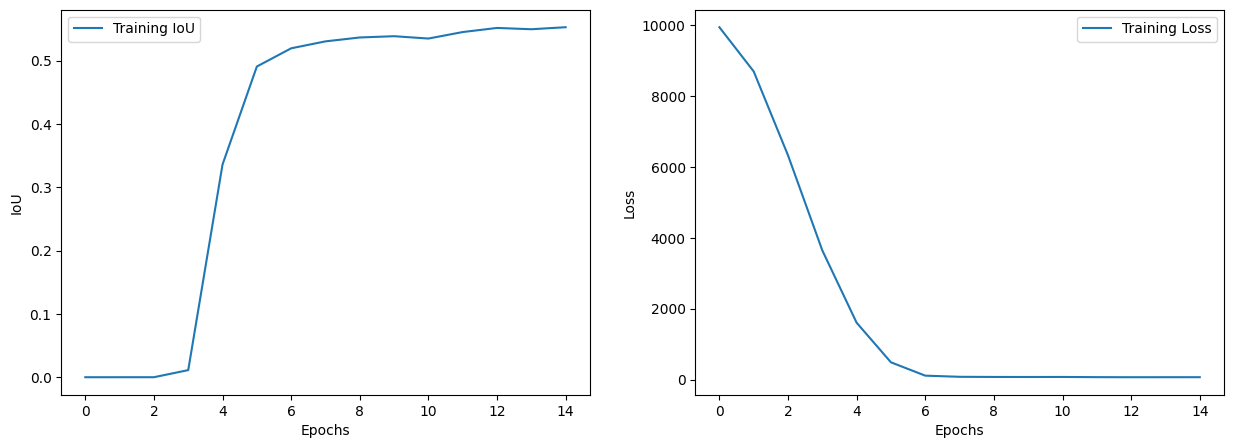

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
model.save('modelx9.h5')